In [107]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import types as sqltypes, create_engine
from langdetect import detect


# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import re
import time
import pickle
import os
from dotenv import load_dotenv



**1.** Recopilar los tweets donde se mencione la cuenta de @TheBridge_Tech desde el
día que comenzaste el bootcamp (21 Noviembre) hasta el último día de clase (7
Marzo).

In [2]:
tweets = []

In [ ]:
query = "(@TheBridge_Tech) until:2023-03-07 since:2022-11-21"

for tweet in sntwitter.TwitterSearchScraper(query).get_items():
  tweets.append([tweet.id, tweet.content, tweet.date, tweet.user.id, tweet.user.username, tweet.user.displayname, tweet.retweetCount, tweet.replyCount, tweet.likeCount, tweet.quoteCount ])

df = pd.DataFrame(tweets, columns=['id', 'content', 'date', 'user_id', 'user_username', 'user_displayname', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount'])
df

In [95]:
df = pd.read_csv('./data/tweets.csv')
df.head()

,id,content,date,user_id,user_username,user_displayname,retweetCount,replyCount,likeCount,quoteCount
0,1632767114380492803,¡Evento #desarrolloweb en #Sevilla con Diego F...,2023-03-06 15:36:30+00:00,1162694149956603904,TheBridge_Tech,The Bridge,3,0,4,0
1,1632746286133702658,¡Súper contentos de participar! Las temáticas ...,2023-03-06 14:13:44+00:00,1162694149956603904,TheBridge_Tech,The Bridge,1,0,1,0
2,1632692123412594688,Las inscripciones se realizarán por Eventbrite...,2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,0,0,0,0
3,1632692120719859712,¡Por fin podemos publicar el cartel con los po...,2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,3,1,5,1
4,1632664546665025536,"Encuentro de la @mlopscommunity en Madrid: ""ML...",2023-03-06 08:48:56+00:00,41545659,nodosenlared,Mario Lopez de Avila,1,0,3,0


- Ya disponemos de la base de datos, procedemos a realizar la división de la misma y breve análisis para saber su composición y si está en condiciones de ser analizada o debe pasar por prepocesamiento de datos.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                175 non-null    int64              
 1   content           175 non-null    object             
 2   date              175 non-null    datetime64[ns, UTC]
 3   user_id           175 non-null    int64              
 4   user_username     175 non-null    object             
 5   user_displayname  175 non-null    object             
 6   retweetCount      175 non-null    int64              
 7   replyCount        175 non-null    int64              
 8   likeCount         175 non-null    int64              
 9   quoteCount        175 non-null    int64              
dtypes: datetime64[ns, UTC](1), int64(6), object(3)
memory usage: 13.8+ KB


In [5]:
df.describe()

,id,user_id,retweetCount,replyCount,likeCount,quoteCount
count,1.750000e+02,1.750000e+02,175.000000,175.000000,175.000000,175.000000
mean,1.612209e+18,6.209114e+17,1.640000,0.262857,5.005714,0.137143
std,1.112227e+16,5.725346e+17,3.927738,0.726781,24.356192,0.495431
min,1.594964e+18,7.154412e+06,0.000000,0.000000,0.000000,0.000000
25%,1.599950e+18,8.152352e+08,0.000000,0.000000,1.000000,0.000000
50%,1.614612e+18,7.020774e+17,1.000000,0.000000,2.000000,0.000000
75%,1.619841e+18,1.162694e+18,2.000000,0.000000,4.000000,0.000000
max,1.632767e+18,1.610074e+18,49.000000,7.000000,322.000000,4.000000


In [6]:
df.isnull().sum()

id                  0
content             0
date                0
user_id             0
user_username       0
user_displayname    0
retweetCount        0
replyCount          0
likeCount           0
quoteCount          0
dtype: int64

In [22]:
df.to_csv('./data/tweets.csv', encoding='utf-8', index=False)

**2.** Almacenarlos en una base de datos SQL desplegada en AWS en 2 tablas
normalizadas: (tweets, usuarios)

primero dividimos el df en las dos tablas requeridas:

In [7]:
df.columns

Index(['id', 'content', 'date', 'user_id', 'user_username', 'user_displayname',
       'retweetCount', 'replyCount', 'likeCount', 'quoteCount'],
      dtype='object')

In [8]:
usuarios = df[['user_id', 'user_username', 'user_displayname']]
tweets = df[['id','user_id', 'content', 'date','retweetCount', 'replyCount', 'likeCount', 'quoteCount']]

In [ ]:
# carga las variables de entorno desde el archivo .env
load_dotenv()

username = os.getenv('USERNAME_DB')
password = os.getenv('PASSWORD')
host = os.getenv('HOST')
port = int(os.getenv('PORT'))
database = "tweets_thebridge"

In [62]:
# carga las variables de entorno desde el archivo .env
load_dotenv()
# Lee las credenciales de la base de datos del archivo .env
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = 'tweets_thebridge'

In [63]:
# Crea la URL de conexión a la base de datos
db_url = f"mysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

In [65]:
# Crea el motor de la base de datos utilizando la URL de conexión
engine = create_engine(db_url)

In [66]:
tweets.to_sql('tweets', con=engine, if_exists='replace', index=False)
usuarios.to_sql('usuarios', con=engine, if_exists='replace', index=False)

175

--------------------------------------------------------------------

**3.** Realizar un pequeño **análisis** donde se respondan a las siguientes preguntas de
negocio:

a. *¿Cuál es el tweet con mayor repercusión social?* 

b. *¿Cuál es el usuario que más menciona a la escuela?*

c. *¿En qué mes se concentra el mayor número de tweets?*

d. *¿Qué palabras son más frecuentes?*

e. *¿Qué tipo de correlación matemática encuentras entre las métricas públicas?*

f. *¿Has sacado alguna conclusión extra en tu análisis?*

In [96]:
pd.set_option('max_colwidth', None)
df.head()

,id,content,date,user_id,user_username,user_displayname,retweetCount,replyCount,likeCount,quoteCount
0,1632767114380492803,"¡Evento #desarrolloweb en #Sevilla con Diego Freniche Brito, Developer Advocate en @MongoDB!\n\nCambiamos de ubicación ¡Te esperamos en @espacio_RES!\n\n📅16 marzo\n⏰18 h\n📍En @espacio_RES \n\nEntradas 👉https://t.co/MJ21xSfIX0 https://t.co/bYJuYAaZ6N",2023-03-06 15:36:30+00:00,1162694149956603904,TheBridge_Tech,The Bridge,3,0,4,0
1,1632746286133702658,"¡Súper contentos de participar! Las temáticas prometen, sin duda 🤩 ¡No te lo pierdas! \n\n📍Universidad @pablodeolavide Sevilla\n🎟Entradas https://t.co/jFvxqPvKTO",2023-03-06 14:13:44+00:00,1162694149956603904,TheBridge_Tech,The Bridge,1,0,1,0
2,1632692123412594688,Las inscripciones se realizarán por Eventbrite. Cualquier duda estamos por MD o al correo info@esoliupo.es\nhttps://t.co/xhVr7VXcF3\n\n@epsUPO @TheBridge_Tech,2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,0,0,0,0
3,1632692120719859712,"¡Por fin podemos publicar el cartel con los ponentes para el #cybersecTalks! Si estás interesadx en alguna de las temáticas que aparecen no dudes en venir, es totalmente gratuito gracias al patrocinio de @TheBridge_Tech y la colaboración de @epsUPO @pablodeolavide \n(+ info abajo) https://t.co/JF85MDGmXc",2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,3,1,5,1
4,1632664546665025536,"Encuentro de la @mlopscommunity en Madrid: ""MLOPs: desde las trincheras"" https://t.co/CHojEAs7ij en @TheBridge_Tech Ven a conocer la práctica #MLOps en Correcto., @Busuu @wallapop https://t.co/odie5CAuHU",2023-03-06 08:48:56+00:00,41545659,nodosenlared,Mario Lopez de Avila,1,0,3,0


a. *`¿Cuál es el tweet con mayor repercusión social?`* 

Para responder esta pregunta, calculo la suma de las columnas retweetCount, replyCount, likeCount y quoteCount y luego elijo el tweet con la mayor suma. 

In [97]:
df['totalInteracciones'] = df['retweetCount'] + df['replyCount'] + df['likeCount'] + df['quoteCount']

max_tweet = df.loc[df['totalInteracciones'].idxmax()]

print('El tweet con mayor repercusión social ha sido:',max_tweet['content'])

El tweet con mayor repercusión social ha sido: Advanced #Cynefin, Estuarine mapping &amp; EUFG Masterclass (Madrid) https://t.co/H5ZSjbKHAr | Los interesados en la aplicación de las ciencias de la complejidad en nuestro país tendremos la oportunidad de aprender de @snowded en persona el 16/3/23 en la sede de @TheBridge_Tech https://t.co/LavCfgYIht


b. *`¿Cuál es el usuario que más menciona a la escuela?`*

Lo que haré aquí es filtrar el dataframe por tweets que mencionen a la escuela y luego contar cuántas veces aparece cada usuario en el dataframe filtrado.

In [99]:
df_mentions = df[df['content'].str.contains('@TheBridge_Tech', case=False)]

In [101]:
# Contar el número de tweets por usuario y ordenar de mayor a menor
users_mentions = df_mentions['user_username'].value_counts().sort_values(ascending=False)
users_mentions.head(3)

BBK_eus           22
jorgegrev         11
TheBridge_Tech     7
Name: user_username, dtype: int64

- aquí podemos ver los 3 primeros, siendo la cuenta de **BBK_eus**, con 22 menciones en la franja de edad estipulada.

c. *`¿En qué mes se concentra el mayor número de tweets?`*

Se creará una nueva columna en el df que contenga el mes de cada tweet y luego contar cuántos tweets hay por mes.

In [102]:
df['mes'] = pd.to_datetime(df['date']).dt.to_period('M')
df['mes'].head()

C:\Users\Leandro\AppData\Local\Temp\ipykernel_16980\1863463909.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['mes'] = pd.to_datetime(df['date']).dt.to_period('M')


0    2023-03
1    2023-03
2    2023-03
3    2023-03
4    2023-03
Name: mes, dtype: period[M]

In [104]:
tweets_per_month = df['mes'].value_counts().sort_values(ascending=False)
tweets_per_month.head()

2023-01    67
2022-12    34
2022-11    33
2023-02    27
2023-03    14
Freq: M, Name: mes, dtype: int64

- Podemos apreciar que en **enero** del presente año, fue el momento de mayor número de tweets.

d. *`¿Qué palabras son más frecuentes?`*

Creando una lista con todas las palabras en los tweets, eliminando las palabras vacías (stopwords), y luego contar cuántas veces aparece cada palabra en la lista, podemos conseguirlo. Las palabras con mayor frecuencia será la que buscamos.

In [105]:
stop_words = set(stopwords.words('spanish'))

all_words = []
for tweet in df['content']:
    for word in tweet.split():
        if word.lower() not in stop_words:
            all_words.append(word.lower())

word_counts = pd.Series(all_words).value_counts().sort_values(ascending=False)
word_counts.head(3)

@thebridge_tech    120
#bbkbootcamps       27
@bbk_eus            27
dtype: int64

- como podemos ver, las menciones y los hashtag son las palabras que más se repiten, por otro lado también tiene sentido, dado que es la 'etiqueta' que se le pone a cada tweet.

e. *`¿Qué tipo de correlación matemática encuentras entre las métricas públicas?`*

Usaremos la función de seaborn de correlación de Pearson:

C:\Users\Leandro\AppData\Local\Temp\ipykernel_16980\567930202.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True);


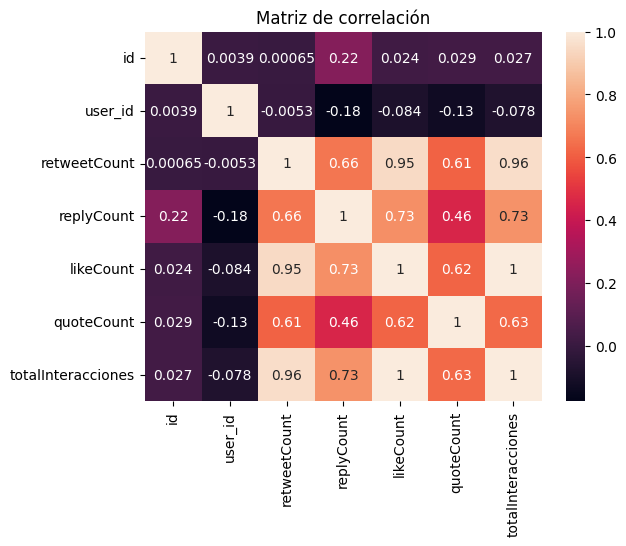

In [108]:
sns.heatmap(df.corr(), annot=True);
plt.title('Matriz de correlación');

Vemos varias relaciones fuertes:

- `likeCount` con `retweetCount` y `totalInteracciones`. Prácticamente se puede decir que si un tweet te ha gustado, lo vas a retweetear.
- `Retweet` con `reply`. Las respuestas y retweets implican comunicación y difusión de algo que para el usuario ha sido de interés.
- Podemos ver que la columna `quoteCount` y `replyCount` guardan una relación moderadamente fuerte, que por otra parte tiene sentido, ya que una es las veces que se contesta a un tweet, mientras que quoteCount es la cantidad de veces que se ha citado o retuiteado un tweet con un comentario y quizás no en todos los casos tenga que estar relacionado. 




In [109]:
df

,id,content,date,user_id,user_username,user_displayname,retweetCount,replyCount,likeCount,quoteCount,totalInteracciones,mes
0,1632767114380492803,"¡Evento #desarrolloweb en #Sevilla con Diego Freniche Brito, Developer Advocate en @MongoDB!\n\nCambiamos de ubicación ¡Te esperamos en @espacio_RES!\n\n📅16 marzo\n⏰18 h\n📍En @espacio_RES \n\nEntradas 👉https://t.co/MJ21xSfIX0 https://t.co/bYJuYAaZ6N",2023-03-06 15:36:30+00:00,1162694149956603904,TheBridge_Tech,The Bridge,3,0,4,0,7,2023-03
1,1632746286133702658,"¡Súper contentos de participar! Las temáticas prometen, sin duda 🤩 ¡No te lo pierdas! \n\n📍Universidad @pablodeolavide Sevilla\n🎟Entradas https://t.co/jFvxqPvKTO",2023-03-06 14:13:44+00:00,1162694149956603904,TheBridge_Tech,The Bridge,1,0,1,0,2,2023-03
2,1632692123412594688,Las inscripciones se realizarán por Eventbrite. Cualquier duda estamos por MD o al correo info@esoliupo.es\nhttps://t.co/xhVr7VXcF3\n\n@epsUPO @TheBridge_Tech,2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,0,0,0,0,0,2023-03
3,1632692120719859712,"¡Por fin podemos publicar el cartel con los ponentes para el #cybersecTalks! Si estás interesadx en alguna de las temáticas que aparecen no dudes en venir, es totalmente gratuito gracias al patrocinio de @TheBridge_Tech y la colaboración de @epsUPO @pablodeolavide \n(+ info abajo) https://t.co/JF85MDGmXc",2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,3,1,5,1,10,2023-03
4,1632664546665025536,"Encuentro de la @mlopscommunity en Madrid: ""MLOPs: desde las trincheras"" https://t.co/CHojEAs7ij en @TheBridge_Tech Ven a conocer la práctica #MLOps en Correcto., @Busuu @wallapop https://t.co/odie5CAuHU",2023-03-06 08:48:56+00:00,41545659,nodosenlared,Mario Lopez de Avila,1,0,3,0,4,2023-03
...,...,...,...,...,...,...,...,...,...,...,...,...
170,1595359906747617280,"¡Ven a conocer los BBK bootcamps powered by @TheBridge_Tech! @BBK_eus \n\nPróximo Open Day🤗\n📅1 dic\n⏰18.30\n📍 @BBK_Kuna, Urazurrutia Kalea 3, Bilbao\n\n¡Lánzate a por una carrera digital!\n \n🎟Entradas https://t.co/NBgXWjSYcE\n\n#uxui #ciber #desarrollowebfullstack #datascience https://t.co/KFsgFfom5B",2022-11-23 10:13:36+00:00,1162694149956603904,TheBridge_Tech,The Bridge,4,0,3,0,7,2022-11
171,1594975696614526979,@HoplaSoftware Deseando teneros @HoplaSoftware en nuestro #RecruitersCorner hablando de #cloud y #talentodigital 🙌,2022-11-22 08:46:53+00:00,1162694149956603904,TheBridge_Tech,The Bridge,0,0,1,0,1,2022-11
172,1594968601265586178,"Acelerando juntos el #talentodigital en España. El próximo 24 de noviembre, nuestro #CEO Juan Zamora presentará Hopla! en las instalaciones de .@TheBridge_Tech a las 17:30h. Contaremos quiénes somos, qué hacemos y cómo desarrollar una #carrerarofesional fructífera con nosotros. https://t.co/Sw9EUswIQ2",2022-11-22 08:18:42+00:00,783248945761910788,HoplaSoftware,Hopla! Software,1,1,3,0,5,2022-11
173,1594965197613322241,"Ikasi gaur etorkizuneko lanbideak, izena eman #BBKBootcamp -ean ⏩ https://t.co/xvm6ekbcMQ\n\n@TheBridge_Tech -ekin batera, Full Stack Web Garapena, Data Science, Zibersegurtasuna eta UX UI produktu digitalaren diseinuari buruz ikasteko aukera izango duzu. https://t.co/oxEOX35Osa",2022-11-22 08:05:10+00:00,702077405045899264,BBK_eus,Fundación BBK | Obra Social,1,0,2,0,3,2022-11


## Limpieza de datos

In [ ]:
# Definición de diccionario que contiene los emojis más comunes con sus significados.

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

- Descargamos los stopwords de la librería **nltk**

In [78]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leandro\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

- Eliminamos los signos de puntuación:

In [90]:
signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\¡)|(\?)|(\#)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

In [91]:
def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

df['content'] = df['content'].apply(signs_tweets)
df['content'].head()

0    evento desarrolloweb en sevilla con diego fren...
1    súper contentos de participar las temáticas pr...
2    las inscripciones se realizarán por eventbrite...
3    por fin podemos publicar el cartel con los pon...
4    encuentro de la mlopscommunity en madrid mlops...
Name: content, dtype: object

- Eliminar links:

In [92]:
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

df['content'] = df['content'].apply(remove_links)

In [79]:

stop_words = stopwords.words('spanish')

In [84]:
print(stop_words)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

Utilizando el método `stem()` de la clase **SnowballStemmer** para obtener la forma base de una palabra en español.

In [ ]:
# Instanciar el stemmer para español
stemmer = SnowballStemmer('spanish')

# Definir una función para lematizar todo el texto
def lemmatize_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

# Aplicar la lematización a la columna 'texto'
df['texto_lemmatizado'] = df['content'].apply(lemmatize_text)

In [69]:
df["idioma"] = df["content"].apply(lambda x: detect(x))

In [70]:
df

,id,content,date,user_id,user_username,user_displayname,retweetCount,replyCount,likeCount,quoteCount,idioma
0,1632767114380492803,¡Evento #desarrolloweb en #Sevilla con Diego F...,2023-03-06 15:36:30+00:00,1162694149956603904,TheBridge_Tech,The Bridge,3,0,4,0,es
1,1632746286133702658,¡Súper contentos de participar! Las temáticas ...,2023-03-06 14:13:44+00:00,1162694149956603904,TheBridge_Tech,The Bridge,1,0,1,0,es
2,1632692123412594688,Las inscripciones se realizarán por Eventbrite...,2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,0,0,0,0,es
3,1632692120719859712,¡Por fin podemos publicar el cartel con los po...,2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,3,1,5,1,es
4,1632664546665025536,"Encuentro de la @mlopscommunity en Madrid: ""ML...",2023-03-06 08:48:56+00:00,41545659,nodosenlared,Mario Lopez de Avila,1,0,3,0,es
...,...,...,...,...,...,...,...,...,...,...,...
170,1595359906747617280,¡Ven a conocer los BBK bootcamps powered by @T...,2022-11-23 10:13:36+00:00,1162694149956603904,TheBridge_Tech,The Bridge,4,0,3,0,es
171,1594975696614526979,@HoplaSoftware Deseando teneros @HoplaSoftware...,2022-11-22 08:46:53+00:00,1162694149956603904,TheBridge_Tech,The Bridge,0,0,1,0,es
172,1594968601265586178,Acelerando juntos el #talentodigital en España...,2022-11-22 08:18:42+00:00,783248945761910788,HoplaSoftware,Hopla! Software,1,1,3,0,es
173,1594965197613322241,"Ikasi gaur etorkizuneko lanbideak, izena eman ...",2022-11-22 08:05:10+00:00,702077405045899264,BBK_eus,Fundación BBK | Obra Social,1,0,2,0,id


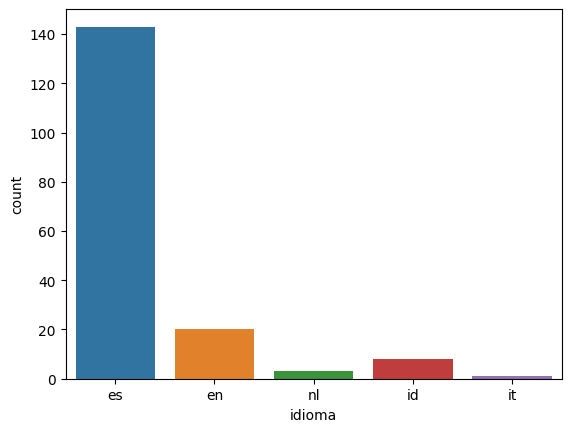

In [72]:
sns.countplot(x="idioma", data=df);

Según la librería, tenemos la gran mayoría de tweets en español, el siguiente más utilizado sería en inglés, y luego detecta "nl" e "id", que son holandes e indonesio respectivamente, pero voy a revisar si es así o no, ya que me suena a que realmente es Euskera:

In [75]:
df.loc[df.idioma == 'nl']

,id,content,date,user_id,user_username,user_displayname,retweetCount,replyCount,likeCount,quoteCount,idioma
80,1615772633773256706,En plena meet-up de CPS en @TheBridge_Tech con...,2023-01-18 18:06:30+00:00,7154412,Recuenco,Javier G. Recuenco,5,2,35,1,nl
138,1598346448138956801,🔙 Atzo oso jardunaldi interesgarria izan genue...,2022-12-01 16:01:03+00:00,702077405045899264,BBK_eus,Fundación BBK | Obra Social,0,0,0,0,nl
159,1597869451222913027,☕️🥐 Jardunaldia enpresentzako gosariarekin has...,2022-11-30 08:25:38+00:00,702077405045899264,BBK_eus,Fundación BBK | Obra Social,0,0,2,0,nl


In [77]:
df.iloc[80].content

'En plena meet-up de CPS en @TheBridge_Tech con @ddamasd https://t.co/MkhnOh2Mzw'